# CNN 307
Start with CNN 306 which overfits most of the time. Reduce #params.

In [57]:
NC_FILENAME='ncRNA.gc36.median.fasta'
PC_FILENAME='pcRNA.gc36.median.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='CNN307'  
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=32
KERNEL=3
NEURONS=32
DROP=0.25
ACT="tanh"
MINLEN=201
MAXLEN=2000

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [60]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    SHAPE=(MAXLEN,5)  # MAXLEN bases = time steps, 5 features = one hots
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[1000])
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    cnn.add(clayer4)
    cnn.add(clayer5)
    cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [61]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='loss',  
            patience=5, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [62]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 2000, 32)          512       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2000, 32)          3104      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1000, 32)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1000, 32)          3104      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 500, 32)           0         
___________________________________________________________

In [63]:
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
(X1,y_train)=tools.separate_X_and_y(subset)
# X1 is pandas df of ("list" of one sequence)
X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
X3=[elem[0] for elem in X2]  # numpy dnarray of str
X4=tools.uniform_length(X3,MAXLEN)
X5= [tools.one_hot(x) for x in X4]
X_train=np.asarray(X5)
y_train=y_train.to_numpy()

subset=None
X1=None
X2=None
X3=None
X4=None
X5=None

Load data from files.
Ready: train_set


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
315/315 [==============================] - 3s 7ms/step - loss: 0.6668 - accuracy: 0.6298 - val_loss: 0.6407 - val_accuracy: 0.6377
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.1.best/assets
Epoch 2/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6426 - accuracy: 0.6385 - val_loss: 0.6018 - val_accuracy: 0.6825
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.1.best/assets
Epoch 3/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6123 - accuracy: 0.6730 - val_loss: 0.6055 - val_accuracy: 0.6771
Epoch 4/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6001 - accuracy: 0.6866 - val_loss: 0.6159 - val_accuracy: 0.6726
Epoch 5/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6214 - accuracy: 0.6687 - val_loss: 0.5848 - val_accuracy: 0.6914
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CN

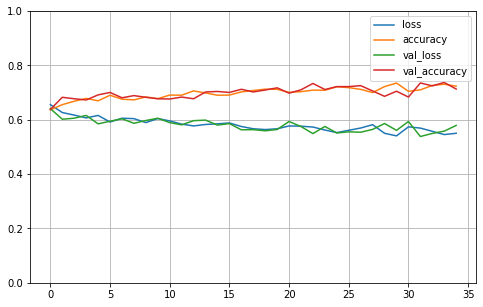

accuracy: 73.70%
COMPILE...
...COMPILED
FIT
Epoch 1/200
315/315 [==============================] - 3s 7ms/step - loss: 0.6722 - accuracy: 0.6143 - val_loss: 0.5763 - val_accuracy: 0.7048
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.2.best/assets
Epoch 2/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6324 - accuracy: 0.6626 - val_loss: 0.6283 - val_accuracy: 0.6995
Epoch 3/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6342 - accuracy: 0.6531 - val_loss: 0.5829 - val_accuracy: 0.7013
Epoch 4/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6246 - accuracy: 0.6682 - val_loss: 0.5815 - val_accuracy: 0.7102
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.2.best/assets
Epoch 5/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6001 - accuracy: 0.6869 - val_loss: 0.5823 - val_accuracy: 0.7048
Epoch 6/200
315/315 [==============================] - 2s 6ms/ste

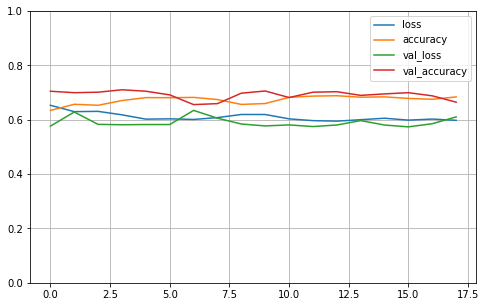

accuracy: 71.02%
COMPILE...
...COMPILED
FIT
Epoch 1/200
315/315 [==============================] - 3s 6ms/step - loss: 0.7018 - accuracy: 0.6023 - val_loss: 0.6079 - val_accuracy: 0.6950
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.3.best/assets
Epoch 2/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6278 - accuracy: 0.6707 - val_loss: 0.5938 - val_accuracy: 0.6941
Epoch 3/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6076 - accuracy: 0.6843 - val_loss: 0.6189 - val_accuracy: 0.6619
Epoch 4/200
315/315 [==============================] - 2s 6ms/step - loss: 0.5971 - accuracy: 0.6886 - val_loss: 0.5917 - val_accuracy: 0.6744
Epoch 5/200
315/315 [==============================] - 2s 6ms/step - loss: 0.5956 - accuracy: 0.6943 - val_loss: 0.5733 - val_accuracy: 0.6905
Epoch 6/200
315/315 [==============================] - 2s 6ms/step - loss: 0.5706 - accuracy: 0.7043 - val_loss: 0.6037 - val_accuracy: 0.7111
INFO:tenso

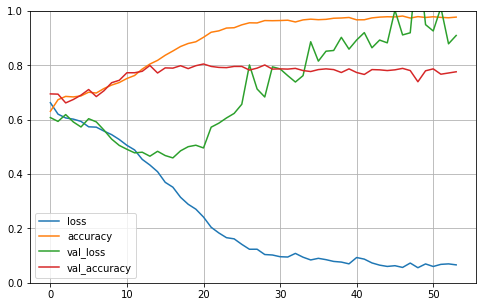

accuracy: 80.50%
COMPILE...
...COMPILED
FIT
Epoch 1/200
315/315 [==============================] - 3s 6ms/step - loss: 0.7228 - accuracy: 0.6116 - val_loss: 0.5878 - val_accuracy: 0.6860
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.4.best/assets
Epoch 2/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6110 - accuracy: 0.6791 - val_loss: 0.5840 - val_accuracy: 0.6986
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.4.best/assets
Epoch 3/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6242 - accuracy: 0.6642 - val_loss: 0.5933 - val_accuracy: 0.6887
Epoch 4/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6143 - accuracy: 0.6766 - val_loss: 0.5949 - val_accuracy: 0.6753
Epoch 5/200
315/315 [==============================] - 2s 6ms/step - loss: 0.5954 - accuracy: 0.6874 - val_loss: 0.5945 - val_accuracy: 0.6825
Epoch 6/200
315/315 [==============================] - 2s 6ms/ste

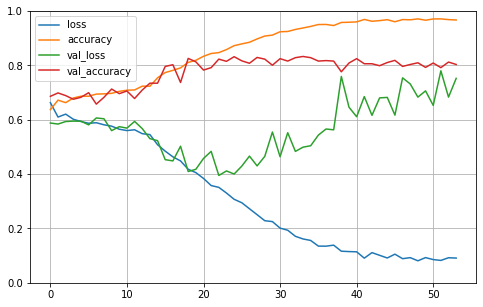

accuracy: 83.27%
COMPILE...
...COMPILED
FIT
Epoch 1/200
315/315 [==============================] - 3s 6ms/step - loss: 0.6935 - accuracy: 0.5968 - val_loss: 0.6272 - val_accuracy: 0.6995
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.5.best/assets
Epoch 2/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6416 - accuracy: 0.6432 - val_loss: 0.6307 - val_accuracy: 0.6494
Epoch 3/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6258 - accuracy: 0.6631 - val_loss: 0.5876 - val_accuracy: 0.6977
Epoch 4/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6335 - accuracy: 0.6528 - val_loss: 0.5922 - val_accuracy: 0.7004
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN307.cv.5.best/assets
Epoch 5/200
315/315 [==============================] - 2s 6ms/step - loss: 0.6153 - accuracy: 0.6690 - val_loss: 0.6360 - val_accuracy: 0.6199
Epoch 6/200
315/315 [==============================] - 2s 6ms/ste

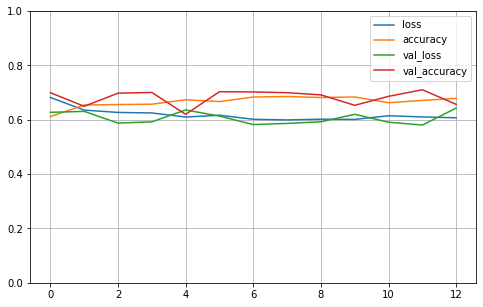

accuracy: 71.02%

5-way Cross Validation mean 75.90% (+/- 5.06%)
Done


In [64]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")